<a href="https://colab.research.google.com/github/hamziqureshi/Emotion_Classification_with_BERT/blob/main/EmotionClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Classification**



#Install the useful libraries here

In [46]:
!pip install transformers
!pip install datasets

#Connect to Google Drive

In [47]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import libraries

In [48]:
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
import numpy as np
from torch.utils.data import DataLoader
from transformers import AdamW
from transformers import get_scheduler
import torch
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Read CSV Emotion dataset

In [49]:
df = pd.read_csv("/content/drive/MyDrive/Data/Emotion_final.csv")
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [50]:
df['Emotion'].value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

#Balance the labels

In [51]:
emotions = df.Emotion.unique()

In [52]:
data = pd.DataFrame()
for i in emotions:
  temp = df[df['Emotion']==i].iloc[:879]
  data = [data, temp]
  data = pd.concat(data)
data

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
5,ive been feeling a little burdened lately wasn...,sadness
10,i feel like i have to make the suffering i m s...,sadness
13,i feel low energy i m just thirsty,sadness
...,...,...
2516,i also feel as it has helped me become an inte...,happy
2519,i feel so blessed just to be her mom,happy
2521,i get the feeling shes amused by all of this,happy
2528,i feel very complacent with my experiences her...,happy


In [53]:
data['Emotion'].value_counts()

sadness     879
anger       879
love        879
surprise    879
fear        879
happy       879
Name: Emotion, dtype: int64

#Convert Text Labels into Numeric Labels

In [54]:
data_dict = {0:'happy', 1:'anger', 2:'love', 3:'surprise', 4:'fear', 5:'sadness'}
my_dict = { data_dict[k]:k for k in data_dict}
data['Emotion'] = [my_dict.get(i,i) for i in list(data['Emotion'])]
data.head()

,Text,Emotion
0,i didnt feel humiliated,5
1,i can go from feeling so hopeless to so damned...,5
5,ive been feeling a little burdened lately wasn...,5
10,i feel like i have to make the suffering i m s...,5
13,i feel low energy i m just thirsty,5


#Split data into train, validation and test

In [55]:
train, test = np.split(data.sample(frac=1, random_state=42), [int(.8*len(data))])

In [56]:
train['Emotion'].value_counts()

5    721
4    716
1    716
2    704
0    700
3    662
Name: Emotion, dtype: int64

In [57]:
test['Emotion'].value_counts()

3    217
0    179
2    175
4    163
1    163
5    158
Name: Emotion, dtype: int64

#Save in your Google Drive

In [58]:
train.to_csv("/content/drive/MyDrive/Data/text_classification/train.csv", index=False)
test.to_csv("/content/drive/MyDrive/Data/text_classification/test.csv", index=False)

#Load Data using datasets library

In [59]:
data_files = {'train': "/content/drive/MyDrive/Data/text_classification/train.csv",
              'test': "/content/drive/MyDrive/Data/text_classification/test.csv"}

In [60]:
dataset = load_dataset('csv', data_files=data_files)

Using custom data configuration default-0b0233e2f456d5b6


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-0b0233e2f456d5b6/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [61]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Text', 'Emotion'],
        num_rows: 4219
    })
    test: Dataset({
        features: ['Text', 'Emotion'],
        num_rows: 1055
    })
})

#Use Tokenizer to prepare dataset

____



In [62]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [63]:
def tokenize_function(example):
    return tokenizer(example["Text"], truncation=True)

In [64]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [65]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['Text', 'Emotion', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4219
    })
    test: Dataset({
        features: ['Text', 'Emotion', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1055
    })
})

In [66]:
tokenized_datasets = tokenized_datasets.remove_columns(["Text"])
tokenized_datasets = tokenized_datasets.rename_column("Emotion", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [67]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [68]:
train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=8, collate_fn=data_collator
)

#Use Model to train dataset

In [69]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=6)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [70]:
optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [71]:
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

1584


In [72]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

#Training

In [73]:
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/1584 [00:00<?, ?it/s]

#Testing

In [74]:
test = []
test_pred = []
model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    test_pred = test_pred + (outputs.logits.argmax(axis=-1).flatten().tolist())
    test = test + batch['labels'].tolist()

In [75]:
test = [data_dict.get(i,i) for i in test]
test_pred = [data_dict.get(i,i) for i in test_pred]

In [76]:
cr_test = classification_report(test,test_pred)
test_accuracy = accuracy_score(test,test_pred)
print("Testing accuracy:", test_accuracy)
print(cr_test)

Testing accuracy: 0.9232227488151659
              precision    recall  f1-score   support

       anger       0.85      0.94      0.89       163
        fear       0.94      0.80      0.86       163
       happy       0.98      0.91      0.94       179
        love       0.94      0.98      0.96       175
     sadness       0.90      0.89      0.90       158
    surprise       0.93      0.99      0.96       217

    accuracy                           0.92      1055
   macro avg       0.92      0.92      0.92      1055
weighted avg       0.92      0.92      0.92      1055



In [77]:
def confusion_ma(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    return plt.show()

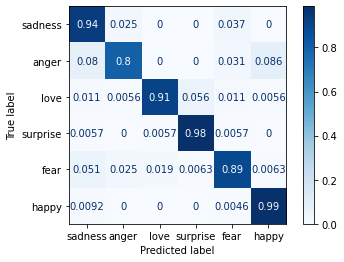

In [78]:
confusion_ma(test,test_pred, emotions)

#User Input

In [80]:
inp = input('Enter Sentence:')
single_tokenized_test = tokenizer(inp,truncation=True, return_tensors='pt')
with torch.no_grad():
  single_tokenized_test = {k: v.to(device) for k, v in single_tokenized_test.items()}
  output = model(**single_tokenized_test)
  single_test_pred = output.logits.argmax(axis=-1).flatten().tolist()
print("The emotion of this sentence is: "+str(data_dict[single_test_pred[0]]))

Enter Sentence:I am so handsome, Masha-ALLAH
The emotion of this sentence is: happy
